In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression

from scipy.stats import ttest_ind
from statsmodels.formula.api import ols
from scipy.stats import t, f_oneway
import pingouin as pg

In [2]:
from statsmodels.stats.multitest import fdrcorrection, fdrcorrection_twostage

In [178]:
def dof_estimate(x1, x2):
    n1, n2 = len(x1), len(x2)
    s1, s2 = x1.var(ddof=1)/n1, x2.var(ddof=1)/n2

    return (s1 + s2)**2 / (s1**2/(n1-1) + s2**2/(n2-1))
    
def t_stat(x1,x2):
    n1, n2 = len(x1), len(x2)
    m1, m2 = x1.mean(), x2.mean()
    s1, s2 = x1.var(ddof=1)/n1, x2.var(ddof=1)/n2
    
    return (m1 - m2) / np.sqrt(s1 + s2)

def t_test_(x1, x2):
    # p-value for 2-sided test
    tstat = t_stat(x1, x2)
    dof = dof_estimate(x1,x2)
    
    return 2*(1 - t.cdf(abs(tstat), dof)), tstat, dof


def t_test(X1, X2):
    assert(np.all(X1.shape==X2.shape))
    n_tests = X1.shape[1]
    pvalues = np.zeros((n_tests,))
    tstats = np.zeros((n_tests,))
    dofs = np.zeros((n_tests,))
    
    for i in range(n_tests):
        p, ts, d = t_test_(X1[:,i], X2[:,i])
        pvalues[i] = p
        tstats[i] = ts
        dofs[i] = d
        
    return pvalues, tstats, dofs


def bh_correction(pvalues, alpha = 0.05, is_sorted=False):
    if is_sorted:
        ix = np.arange(len(pvalues))
        ixix = ix
    else:
        ix = np.argsort(pvalues)
        ixix = np.argsort(ix)
    
    m = len(pvalues)
    pvals = pvalues[ix]
    Ghat = np.arange(1,m+1)/m
    
    pvals /= Ghat
    h = pvals<=alpha
    
    return h[ixix], np.minimum(1,pvals[ixix])
    
    
def by_correction(pvalues, alpha = 0.05, is_sorted=False):
    if is_sorted:
        ix = np.arange(len(pvalues))
        ixix = ix
    else:
        ix = np.argsort(pvalues)
        ixix = np.argsort(ix)
    
    pvals = pvalues[ix]
    m = len(pvalues)
    c_m=np.sum(1./np.arange(1,m+1))
    Ghat = np.arange(1,m+1)/m
    
    pvals /= Ghat/c_m
    
    for i in range(m-1, 0, -1):
        if(pvals[i-1]>pvals[i]):
            pvals[i-1]=pvals[i]
    h = pvals <= alpha
    return h[ixix], np.minimum(1,pvals[ixix])
    


In [3]:
path = "../../../PARKINSONS/PDproj/celldata/clean/"
filenames = [line.split('\n')[0] for line in open(path + "filenames.txt")]
filenames

['cellshilicneg_log2.csv',
 'cellshilicpos_log2.csv',
 'cellsRPneg_log2.csv',
 'cellsRPpos_log2.csv',
 'cellslipidomicsneg_log2.csv',
 'cellslipidomicspos_log2.csv',
 'mediumHILICneg_log2.csv',
 'mediumHILICpos_log2.csv',
 'mediumRPneg_log2.csv',
 'mediumRPpos_log2.csv']

In [13]:
fnum=0 # 2 is good example
fname = filenames[fnum]
data = pd.read_csv(path + fname, sep=';', header=None)
fname

'cellshilicneg_log2.csv'

In [14]:
path_s = "../../../PARKINSONS/PDproj/cellresults/ttest/withGF/ALPHA0.05FC1.0MINVAR0.125/"
filenames_s = [line.split('\n')[0] for line in open(path_s + "filenames.txt")]
print(filenames_s[fnum])
df_s = pd.read_csv(path_s + filenames_s[fnum],sep=';')

masstime_s = np.unique(df_s[' masstime'].to_numpy())

cellshilicnegALPHA0.05FC1.0MINVAR0.125.csv


In [15]:
df_s.iloc[np.where(df_s[' masstime']=="306.07662@6.725")[0],:]

,compound,masstime,testi,p_orig,p_FDR,p_Bonf,FC,ms,mv1,mv2
0,L-Glutathione (reduced),306.07662@6.725,comb.--UT,3.521294e-07,0.000699,0.000202,1.485396,0.450677,0,0
1,L-Glutathione (reduced),306.07662@6.725,INFg--UT,5.766389e-06,0.003271,0.003304,1.271771,0.000000,0,0
2,L-Glutathione (reduced),306.07662@6.725,aSYN--comb.,1.429716e-05,0.005008,0.008192,-1.636064,0.580163,0,0
4,L-Glutathione (reduced),306.07662@6.725,aSYN--INFg,4.899348e-05,0.012157,0.028073,-1.422439,0.000000,0,0


In [16]:
metadata = data.iloc[3:,:8]
masstime = np.array(["{}@{}".format(m,t) for m,t in zip(metadata.iloc[:,4],metadata.iloc[:,5])])
Area = data.iloc[3:,8:48]
groups = data.iloc[0,8:48]
LE = LabelEncoder()
labels = LE.fit_transform(groups)

In [17]:
X=Area.to_numpy(dtype=float).T

In [18]:
pick_ind = np.where(masstime=="306.07662@6.725")[0][0]
pick_ind

96

In [19]:
metadata.iloc[pick_ind,:]

0    L-Glutathione (reduced)
1            C10 H17 N3 O6 S
2                       0.29
3                   307.0839
4                  306.07662
5                      6.725
6      DDA for preferred ion
7                    [M-H]-1
Name: 99, dtype: object

In [20]:
ttest_ind(X[:10,pick_ind],X[10:20,pick_ind], equal_var=False)

Ttest_indResult(statistic=-7.078108796836535, pvalue=1.42971624049035e-05)

In [23]:
t_test_(X[:10,pick_ind],X[10:20,pick_ind])

(1.4297162404863784e-05, -7.078108796836535, 11.767117912369418)

In [24]:
from numba import njit, prange
from numba_stats import t as numba_t

@njit(parallel=False)
def dof_estimate_par(x1, x2):
    n1, n2 = len(x1), len(x2)
    #s1, s2 = x1.var()/n1, x2.var()/n2
    s1 = (x1-x1.mean()).T@(x1-x1.mean())/(len(x1)-1)/n1
    s2 = (x2-x2.mean()).T@(x2-x2.mean())/(len(x2)-1)/n2

    return (s1 + s2)**2 / (s1**2/(n1-1) + s2**2/(n2-1))

@njit(parallel=False)
def t_stat_par(x1,x2):
    n1, n2 = len(x1), len(x2)
    m1, m2 = x1.mean(), x2.mean()
    #s1, s2 = x1.var()/n1, x2.var()/n2
    s1 = (x1-x1.mean()).T@(x1-x1.mean())/(len(x1)-1)/n1
    s2 = (x2-x2.mean()).T@(x2-x2.mean())/(len(x2)-1)/n2
    
    return (m1 - m2) / np.sqrt(s1 + s2)

@njit(parallel=False)
def t_test_par(x1, x2):
    # p-value for 2-sided test
    tstat = t_stat_par(x1, x2)
    dof = dof_estimate_par(x1,x2)
    
    return 2*(1 - numba_t.cdf(abs(tstat), dof)), tstat, dof


@njit(parallel=False)
def test_run(X1, X2):
    tstats = np.zeros((X1.shape[1],), dtype=float)
    dofs = np.zeros((X1.shape[1],), dtype=float)
    
    for i in range(X1.shape[1]):
        ts = t_stat_par(X1[:,i], X2[:,i])
        d = dof_estimate_par(X1[:,i], X2[:,i])
        
        tstats[i] = ts
        dofs[i] = d
    
    return tstats, dofs 
    
@njit(parallel=False)
def make_newX(X, ind):
    # include the unpermuted data
    if ind==0:
        group_ind = np.arange(40)
    else:
        group_ind = np.random.choice(np.arange(40),40, replace=False)
    
    group_ind1 = group_ind[:10]
    group_ind2 = group_ind[10:20]
    group_ind3 = group_ind[20:30]
    group_ind4 = group_ind[30:]

    X_rand = np.hstack((np.vstack((X[group_ind1,:],X[group_ind2,:])),
               np.vstack((X[group_ind1,:],X[group_ind3,:])),
               np.vstack((X[group_ind1,:],X[group_ind4,:])),
               np.vstack((X[group_ind2,:],X[group_ind3,:])),
               np.vstack((X[group_ind2,:],X[group_ind4,:])),
               np.vstack((X[group_ind3,:],X[group_ind4,:])),))
    return X_rand

@njit(parallel=True)
def group_permutation(X, it=1000):
    s = np.ones((it, X.shape[1]*6))
    d = np.ones((it, X.shape[1]*6))
    
    for i in prange(0,it):
        X_new = make_newX(X, i)
        ss, dd = test_run(X_new[:10,:],X_new[10:,:])
        s[i,:]=ss
        d[i,:]=dd
        
    return s, d

#############################################################################################
    
def dof_estimate(x1, x2):
    n1, n2 = len(x1), len(x2)
    s1, s2 = x1.var(ddof=1)/n1, x2.var(ddof=1)/n2

    return (s1 + s2)**2 / (s1**2/(n1-1) + s2**2/(n2-1))
    
def t_stat(x1,x2):
    n1, n2 = len(x1), len(x2)
    m1, m2 = x1.mean(), x2.mean()
    s1, s2 = x1.var(ddof=1)/n1, x2.var(ddof=1)/n2
    
    return (m1 - m2) / np.sqrt(s1 + s2)

def t_test_(x1, x2):
    # p-value for 2-sided test
    tstat = t_stat(x1, x2)
    dof = dof_estimate(x1,x2)
    
    return 2*(1 - t.cdf(abs(tstat), dof)), tstat, dof


def t_test(X1, X2):
    assert(np.all(X1.shape==X2.shape))
    n_tests = X1.shape[1]
    pvalues = np.zeros((n_tests,))
    tstats = np.zeros((n_tests,))
    dofs = np.zeros((n_tests,))
    
    for i in range(n_tests):
        p, ts, d = t_test_(X1[:,i], X2[:,i])
        pvalues[i] = p
        tstats[i] = ts
        dofs[i] = d
        
    return pvalues, tstats, dofs


def group_pvalues(stats, dofs):
    pvalues = np.ones_like(stats)
    for i in range(pvalues.shape[0]):
        for j in range(pvalues.shape[1]):
            p = 2*(1 - t.cdf(abs(stats[i,j]), dofs[i,j]))
            pvalues[i,j]=p
    return pvalues

def group_pvalues_par(stats, dofs):
    pvalues = np.ones_like(stats)
    for i in prange(pvalues.shape[0]):
        p = 2*(1 - t.cdf(abs(stats[i,:]), dofs[i,:]))
        pvalues[i,:]=p
    return pvalues

In [25]:
group_ind1=np.arange(10)
group_ind2=np.arange(10,20)
group_ind3=np.arange(20,30)
group_ind4=np.arange(30,40)

X_all = np.hstack((np.vstack((X[group_ind1,:],X[group_ind2,:])),
           np.vstack((X[group_ind1,:],X[group_ind3,:])),
           np.vstack((X[group_ind1,:],X[group_ind4,:])),
           np.vstack((X[group_ind2,:],X[group_ind3,:])),
           np.vstack((X[group_ind2,:],X[group_ind4,:])),
           np.vstack((X[group_ind3,:],X[group_ind4,:])),))
p,_,__=t_test(X_all[:10,:],X_all[10:,:])

In [26]:
resPERM = group_permutation(X,it=1000)

In [27]:
ps = group_pvalues_par(resPERM[0], resPERM[1])

In [28]:
new_p=np.sort(ps,axis=1)[:int(np.floor(ps.shape[1]*0.05))]

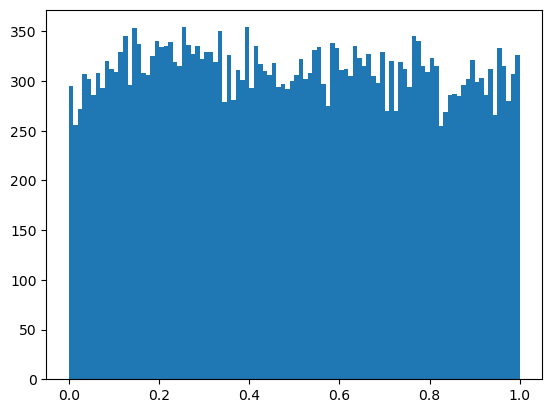

In [29]:
plt.hist(new_p.flatten(), bins=100)
plt.show()

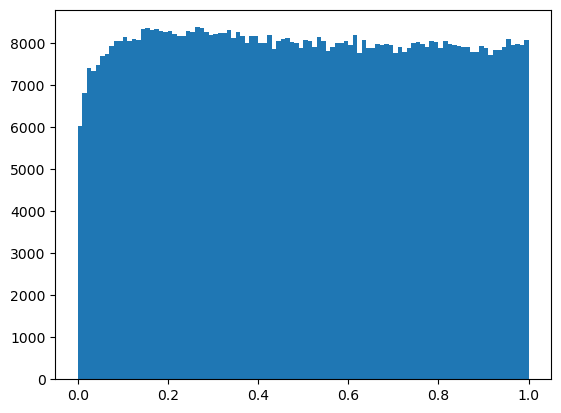

In [30]:
plt.hist(ps.flatten(), bins=100)
plt.show()

In [31]:
p_all = np.sort(ps.flatten())
p_all[int(np.floor(0.05*len(p_all)))]

0.05634408240558786

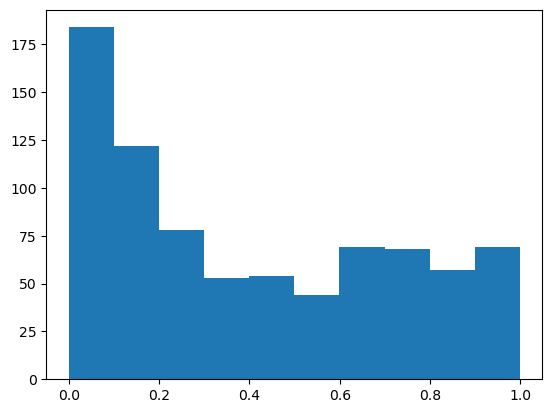

In [32]:
plt.hist(ps[0,:])
plt.show()

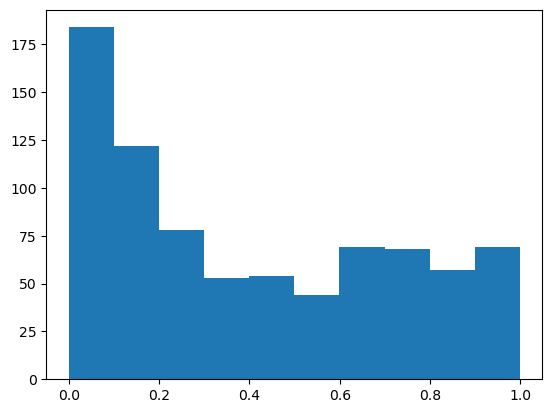

In [33]:
plt.hist(p)
plt.show()

In [136]:
pvals, stats, dofs = t_test(X_all[:10,:], X_all[10:,:])

In [137]:
resBY = fdrcorrection(pvals, alpha=0.05, method='n', is_sorted=False)

In [138]:
resby = by_correction(pvals, is_sorted=False)

In [139]:
np.sum(resby[0])

23

In [140]:
np.sum(resBY[0])

23

In [141]:
np.sort(resby[1])[:23]

array([0.00012245, 0.00081306, 0.00172098, 0.00172098, 0.00224476,
       0.00380413, 0.00380413, 0.00390739, 0.00443034, 0.00582536,
       0.00582536, 0.00582536, 0.00846814, 0.00970624, 0.01297688,
       0.01414059, 0.02384883, 0.026581  , 0.03203058, 0.03463381,
       0.03680455, 0.0422127 , 0.04807682])

In [248]:
print(t_test_(X[:10,pick_ind],X[10:20,pick_ind]),'\n')
print(t_test_(X[:10,pick_ind],X[20:30,pick_ind]),'\n')
print(t_test_(X[:10,pick_ind],X[30:,pick_ind]),'\n')
print(t_test_(X[10:20,pick_ind],X[20:30,pick_ind]),'\n')
print(t_test_(X[10:20,pick_ind],X[30:,pick_ind]),'\n')
print(t_test_(X[20:30,pick_ind],X[30:,pick_ind]),'\n')

(8.543295853202793e-06, -7.460981774825836, 11.767117912369418) 

(2.787508385804216e-05, -5.879548970902987, 15.30687267179199) 

(0.5497319681778765, -0.6111919406430332, 15.861949929349908) 

(0.18401342648788566, 1.3925232355674768, 15.037749807977788) 

(1.8297943338296818e-07, 9.252351976230951, 14.49012759954857) 

(2.929281677888085e-06, 6.682514782640689, 17.93142954880716) 



In [246]:
pvals, stats, dofs = t_test(X[:10,:], X[10:20, :])

In [247]:
pvals.shape

(133,)

In [249]:
f_oneway(X[:10,pick_ind],X[10:20,pick_ind],X[20:30,pick_ind],X[30:,pick_ind])

F_onewayResult(statistic=30.575686933620617, pvalue=5.270536181484816e-10)

In [250]:
df_test = pd.DataFrame({'score':X[:,pick_ind],'group':groups})
pg.welch_anova(dv='score',between='group', data=df_test)

,Source,ddof1,ddof2,F,p-unc,np2
0,group,3,19.039426,34.722007,6.387264e-08,0.718149


In [251]:
group_ind1=np.arange(10)
group_ind2=np.arange(10,20)
group_ind3=np.arange(20,30)
group_ind4=np.arange(30,40)
X_test1 = np.hstack((X[group_ind1,pick_ind],X[group_ind2,pick_ind]))
groups1 = groups.to_numpy()[np.hstack((group_ind1,group_ind2))]

X_test2 = np.hstack((X[group_ind1,pick_ind],X[group_ind3,pick_ind]))
groups2 = groups.to_numpy()[np.hstack((group_ind1,group_ind3))]

X_test3 = np.hstack((X[group_ind1,pick_ind],X[group_ind4,pick_ind]))
groups3 = groups.to_numpy()[np.hstack((group_ind1,group_ind4))]

X_test4 = np.hstack((X[group_ind2,pick_ind],X[group_ind3,pick_ind]))
groups4 = groups.to_numpy()[np.hstack((group_ind2,group_ind3))]

X_test5 = np.hstack((X[group_ind2,pick_ind],X[group_ind4,pick_ind]))
groups5 = groups.to_numpy()[np.hstack((group_ind2,group_ind4))]

X_test6 = np.hstack((X[group_ind3,pick_ind],X[group_ind4,pick_ind]))
groups6 = groups.to_numpy()[np.hstack((group_ind3,group_ind4))]

df_test1 = pd.DataFrame({'score':X_test1,'group':groups1})
df_test2 = pd.DataFrame({'score':X_test2,'group':groups2})
df_test3 = pd.DataFrame({'score':X_test3,'group':groups3})
df_test4 = pd.DataFrame({'score':X_test4,'group':groups4})
df_test5 = pd.DataFrame({'score':X_test5,'group':groups5})
df_test6 = pd.DataFrame({'score':X_test6,'group':groups6})

print(pg.welch_anova(dv='score',between='group', data=df_test1),'\n')
print(pg.welch_anova(dv='score',between='group', data=df_test2),'\n')
print(pg.welch_anova(dv='score',between='group', data=df_test3),'\n')
print(pg.welch_anova(dv='score',between='group', data=df_test4),'\n')
print(pg.welch_anova(dv='score',between='group', data=df_test5),'\n')
print(pg.welch_anova(dv='score',between='group', data=df_test6),'\n')

  Source  ddof1      ddof2          F     p-unc       np2
0  group      1  11.767118  50.099624  0.000014  0.735681 

  Source  ddof1      ddof2          F     p-unc       np2
0  group      1  15.306873  31.112186  0.000049  0.633492 

  Source  ddof1     ddof2       F     p-unc       np2
0  group      1  15.86195  0.3362  0.570176  0.018335 

  Source  ddof1     ddof2         F     p-unc       np2
0  group      1  15.03775  1.745209  0.206231  0.088386 

  Source  ddof1      ddof2          F         p-unc       np2
0  group      1  14.490128  77.045415  3.521294e-07  0.810617 

  Source  ddof1     ddof2          F     p-unc       np2
0  group      1  17.93143  40.190403  0.000006  0.690671 



In [252]:
print(t_test_(X[:10,pick_ind],X[10:20,pick_ind]),'\n')
print(t_test_(X[:10,pick_ind],X[20:30,pick_ind]),'\n')
print(t_test_(X[:10,pick_ind],X[30:,pick_ind]),'\n')
print(t_test_(X[10:20,pick_ind],X[20:30,pick_ind]),'\n')
print(t_test_(X[10:20,pick_ind],X[30:,pick_ind]),'\n')
print(t_test_(X[20:30,pick_ind],X[30:,pick_ind]),'\n')

(8.543295853202793e-06, -7.460981774825836, 11.767117912369418) 

(2.787508385804216e-05, -5.879548970902987, 15.30687267179199) 

(0.5497319681778765, -0.6111919406430332, 15.861949929349906) 

(0.18401342648788566, 1.3925232355674768, 15.037749807977788) 

(1.8297943338296818e-07, 9.252351976230951, 14.49012759954857) 

(2.929281677888085e-06, 6.682514782640689, 17.93142954880716) 



In [56]:
res=pg.welch_anova(dv='score',between='group', data=df_test)
res

,Source,ddof1,ddof2,F,p-unc,np2
0,group,3,19.039426,34.722007,6.387264e-08,0.718149


In [58]:
pg.pairwise_gameshowell(dv='score', between='group', data=df_test)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,INFg,UT,23.045073,21.773302,1.271771,0.200608,6.339590,17.931430,0.000032,2.715356
1,INFg,aSYN,23.045073,21.622634,1.422439,0.255017,5.577830,15.306873,0.000258,2.389081
2,INFg,comb.,23.045073,23.258698,-0.213625,0.161707,-1.321064,15.037750,0.564350,-0.565834
3,UT,aSYN,21.773302,21.622634,0.150668,0.259850,0.579828,15.861950,0.936695,0.248350
4,UT,comb.,21.773302,23.258698,-1.485396,0.169227,-8.777552,14.490128,0.000002,-3.759577
5,aSYN,comb.,21.622634,23.258698,-1.636064,0.231144,-7.078109,11.767118,0.000073,-3.031676


In [239]:
pvals  = pvals[np.argsort(pvals)]

In [228]:
resBH = fdrcorrection(pvals, alpha=0.05, method='indep', is_sorted=True)

In [240]:
resbh = bh_correction(pvals, is_sorted=True)

In [299]:
resby = by_correction(pvals, is_sorted=True)

In [107]:
resBY = fdrcorrection(pvals, alpha=0.05, method='n', is_sorted=False)

In [108]:
np.sum(resBY[0])

11

In [302]:
np.sum(resby[0])

11